# Difusão na Superfície usando VASP e ASE

Autor: [Prof. Elvis do A. Soares](https://github.com/elvissoares) 

Contato: [elvis@peq.coppe.ufrj.br](mailto:elvis@peq.coppe.ufrj.br) - [Programa de Engenharia Química, PEQ/COPPE, UFRJ, Brasil](https://www.peq.coppe.ufrj.br/)

---

Importando variáveis do VASP

In [1]:
import os
# Definindo o path para os arquivos de potencial de pseudopotenciais do VASP
# Certifique-se de que o caminho esteja correto para o seu sistema
os.environ['VASP_PP_PATH'] = '/home/elvis/Programs/vasp-6.5.1/pp'
os.environ['ASE_VASP_COMMAND'] = 'mpirun -np 1 vasp_std_gpu'
os.environ['NO_STOP_MESSAGE'] = '1' # to avoid warning from mpirun

# Importando o VASP calculator do ASE
from ase.calculators.vasp import Vasp

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms, Atom
from ase.build import molecule

from ase.io import read, write
from ase.visualize import view

# Difusão de Átomo de O em Pt(111)

## Estado Inicial: O(hcp) em Pt(111)

In [ ]:
from ase.build import fcc111
from ase.build import add_adsorbate
from ase.constraints import FixAtoms, FixedLine

Co3O4

Pt111_slab = fcc111("Pt", size=(2,2,4), vacuum=6.0,periodic=True)

initial_state = Pt111_slab.copy()

# adicionando átomo de O na posição fcc
add_adsorbate(initial_state, adsorbate="O", height=1.2461, position="hcp")

# ficando os átomos de Pt
constraint = FixAtoms(mask=[atom.symbol=='Pt' for atom in initial_state])
# permitindo que o átomo de O se mova somente em z
c = FixedLine(
    indices=[atom.index for atom in initial_state if atom.symbol in 'O'],
    direction=[0, 0, 1],
)
initial_state.set_constraint([constraint,c])

print(initial_state)

Atoms(symbols='Pt16O', pbc=True, cell=[[5.5437171645025325, 0.0, 0.0], [2.7718585822512662, 4.800999895855028, 0.0], [0.0, 0.0, 18.78963916567]], tags=..., constraint=[FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]), FixedLine(indices=[16], [0.0, 0.0, 1.0])])


In [4]:
view(initial_state, viewer='x3d')

In [5]:
calc = Vasp(directory='difusao/O_Pt111_hcp',
            xc='PBE',                                   # funcional
            encut=450,                                  # safe default for PAW-PBE sets
            kpts=[1, 1, 1],gamma=True,                  # k-points
            ismear=0, sigma=0.05,                       # Gaussian smearing for molecules
            ediff=1e-6, ediffg=-0.02,                   # SCF and force criteria (~0.02 eV/Å)
            ibrion=2, nsw=100,                           # adjusting ionic positions 
            lreal='Auto',
            lwave=True, lcharg=True,lvtot=True,  # keep WAVECAR/CHGCAR/LOCPOT for post-processing
            atoms=initial_state)

calc.calculate(initial_state)

In [ ]:
E_i = initial_state.get_potential_energy()

print("Energia do sistema Pt(111) + O (hcp) = {:.3f} eV".format(E_i))

Energia do O em Pt(111) no sítio hcp = -63.959 eV


## Estado Final: O(fcc) em Pt(111)

Carregando a geometria do slab relaxada

In [7]:
final_state = Pt111_slab.copy()

# adicionando átomo de O na posição fcc
add_adsorbate(final_state, adsorbate="O", height=1.311, position="fcc")

# ficando os átomos de Pt
constraint = FixAtoms(mask=[atom.symbol=='Pt' for atom in final_state])
# permitindo que o átomo de O se mova somente em z
c = FixedLine(
    indices=[atom.index for atom in final_state if atom.symbol in 'O'],
    direction=[0, 0, 1],
)
final_state.set_constraint([constraint,c])

print(final_state)

Atoms(symbols='Pt16O', pbc=True, cell=[[5.5437171645025325, 0.0, 0.0], [2.7718585822512662, 4.800999895855028, 0.0], [0.0, 0.0, 18.78963916567]], tags=..., constraint=[FixAtoms(indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]), FixedLine(indices=[16], [0.0, 0.0, 1.0])])


In [8]:
view(final_state, viewer='x3d')

In [9]:
calc = Vasp(directory='difusao/O_Pt111_fcc',
            xc='PBE',                                   # funcional
            encut=450,                                  # safe default for PAW-PBE sets
            kpts=[1, 1, 1],gamma=True,                  # k-points
            ismear=0, sigma=0.05,                       # Gaussian smearing for molecules
            ediff=1e-6, ediffg=-0.02,                   # SCF and force criteria (~0.02 eV/Å)
            ibrion=2, nsw=100,                          # adjusting ionic positions 
            lreal='Auto',
            lwave=True, lcharg=True,lvtot=True,  # keep WAVECAR/CHGCAR/LOCPOT for post-processing
            atoms=final_state)

calc.calculate(final_state)

In [10]:
E_f = final_state.get_potential_energy()

print("Energia do sistema Pt(111) + O (fcc) = {:.3f} eV".format(E_f))

Energia do sistema Pt(111) + O (fcc) = -64.427 eV


## Estados Intermediários: NEB

In [13]:
from ase.mep import NEB
from ase.optimize import FIRE

# Recuperando os estados inicial e final
calc = Vasp(restart=True,directory='difusao/O_Pt111_hcp')
initial = calc.get_atoms()

calc = Vasp(restart=True,directory='difusao/O_Pt111_fcc')
final = calc.get_atoms()

# Definindo vínculos para os átomos de Pt
constraint = FixAtoms(mask=[atom.symbol=='Pt' for atom in initial])
initial.set_constraint(constraint)
final.set_constraint(constraint)

# 1) Make band with N images between A and B
nimages = 3                        # internal images (exclude endpoints)
images = [initial]

# 2) Attach one VASP calculator per internal image (single-point forces only)
for i in range(nimages):
    image = initial.copy()
    image.set_constraint(constraint)
    image.calc = Vasp(
        directory=f'difusao/O_Pt111_neb/{i:02d}',
        xc='PBE', encut=450,
        kpts=[1,1,1], gamma=True,    # adjust if periodic/metallic
        ismear=0, sigma=0.05,        # molecules; for metals use ismear=1, sigma~0.2
        ibrion=-1, nsw=0,            # NEB optimizer moves atoms; VASP only gives E,F
    )
    images.append(image)

images.append(final)

# 3) CI-NEB with IDPP-preconditioned path
neb = NEB(images, k=0.1, climb=True)
neb.interpolate(apply_constraint=True)     # better initial path than linear

# 4) Optimize the band (FIRE/BFGS are fine; maximum step of 0.8 Å)
opt = FIRE(neb,a = 0.25, dt = 0.1, maxstep=0.25, trajectory='O_Pt111_neb.traj', logfile='O_Pt111_neb.log')
opt.run(fmax=0.05)

np.True_

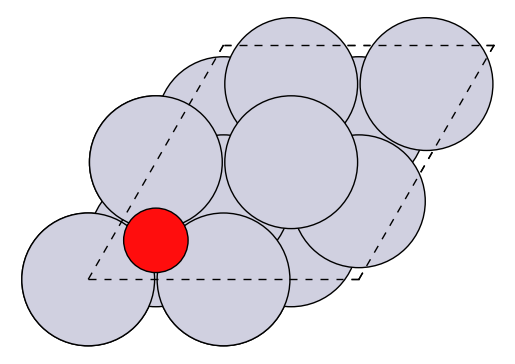

In [19]:
from ase.io import Trajectory

traj = Trajectory("O_Pt111_neb.traj")
write("O_Pt111_diffusion_NEB.gif", traj, rotation="0x,0y,0z")

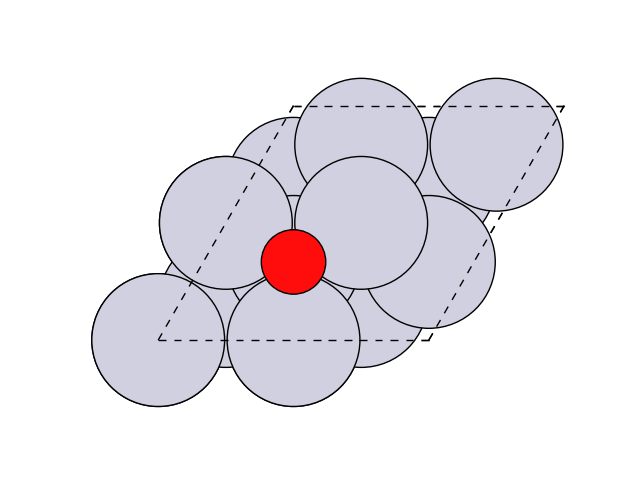

In [20]:
from IPython.display import Image
Image("O_Pt111_diffusion_NEB.gif", format="gif", width=500)

In [16]:
from ase.mep import NEBTools

#Barrier analysis and plot
tools = NEBTools(images)
Ef, dE = tools.get_barrier()        # Ef = forward barrier (eV), dE = reaction energy (eV)
print(f'Forward barrier: {Ef:.3f} eV \nReaction energy: {dE:.3f} eV')

Forward barrier: 0.135 eV 
Reaction energy: -0.468 eV


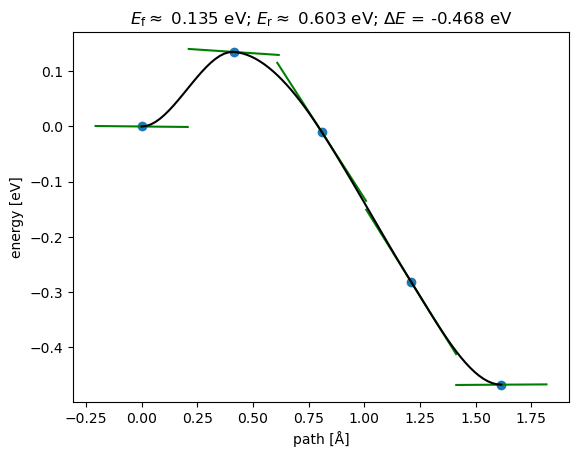

In [17]:
fig = tools.plot_band()     # energy vs. reaction coordinate
fig.savefig('O_Pt111_diffusion_NEB_barrier.png')